<a href="https://colab.research.google.com/github/Shervinrtd/knowledge-Injection/blob/main/knowledge_Injection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install libraries**

In [1]:
!pip install pandas datasets
!pip install pandas networkx matplotlib spacy
!python -m spacy download en_core_web_sm

**Imports & Setup**

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from google.colab import drive
from datasets import load_dataset
from google.colab import drive
import os

**Data Loader**

In [2]:

# 1. MOUNT GOOGLE DRIVE
# When you run this, it will ask for permission to access your Drive. Click "Allow".
drive.mount('/content/drive')

def download_and_process_data():
    print("⬇  Downloading PubMedQA dataset...")

    # Load the dataset
    dataset = load_dataset("pubmed_qa", "pqa_labeled", split="train")

    # Extract data
    data = []
    for item in dataset:
        row = {
            "id": item["pubid"],
            "question": item["question"],
            "context": "".join(item["context"]["contexts"]),
            "answer": item["long_answer"]
        }
        data.append(row)

    df = pd.DataFrame(data)

    # 2. SAVE TO DRIVE
    # This creates a folder "NLP_Project" in your Drive and saves the file there.
    output_folder = "/content/drive/My Drive/NLP_Project/data"
    os.makedirs(output_folder, exist_ok=True)

    output_path = f"{output_folder}/pubmed_qa_clean.csv"

    df.to_csv(output_path, index=False)
    print(f" SUCCESS! Data saved to your Google Drive at: {output_path}")
    print(f" Total samples: {len(df)}")
    return df

# Run the function
df = download_and_process_data()
df.head()

Mounted at /content/drive
⬇  Downloading PubMedQA dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

 SUCCESS! Data saved to your Google Drive at: /content/drive/My Drive/NLP_Project/data/pubmed_qa_clean.csv
 Total samples: 1000


,id,question,context,answer
0,21645374,Do mitochondria play a role in remodelling lac...,Programmed cell death (PCD) is the regulated d...,Results depicted mitochondrial dynamics in viv...
1,16418930,Landolt C and snellen e acuity: differences in...,Assessment of visual acuity depends on the opt...,"Using the charts described, there was only a s..."
2,9488747,"Syncope during bathing in infants, a pediatric...",Apparent life-threatening events in infants ar...,"""Aquagenic maladies"" could be a pediatric form..."
3,17208539,Are the long-term results of the transanal pul...,The transanal endorectal pull-through (TERPT) ...,Our long-term study showed significantly bette...
4,10808977,Can tailored interventions increase mammograph...,Telephone counseling and tailored print commun...,The effects of the intervention were most pron...


**Build Knowledge Graph**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1000 rows.
Building Graph...
Graph built with 80 nodes and 46 edges.


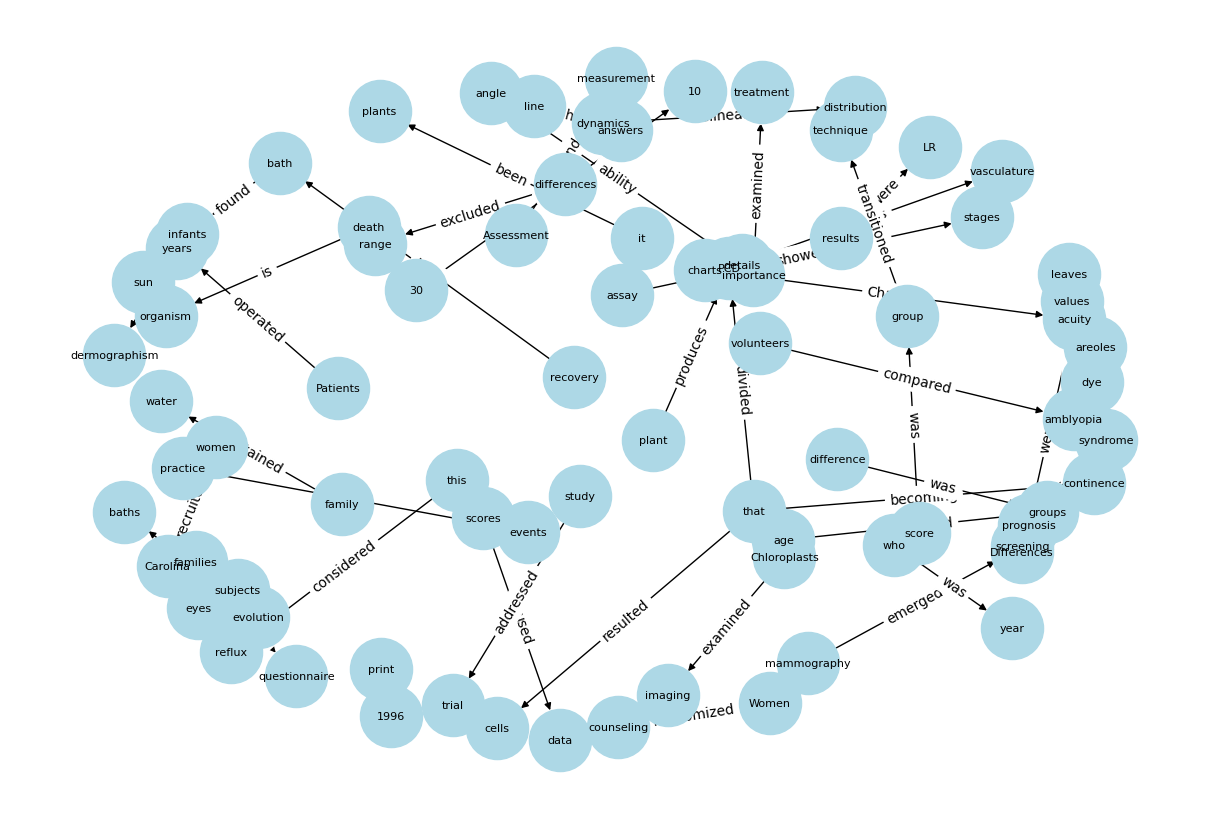

In [4]:
# Cell 1: Install Libraries
# Mount Drive
drive.mount('/content/drive')

# Load the NLP model (Spacy) - simpler than an LLM for now, good for testing
nlp = spacy.load("en_core_web_sm")

# Cell 3: Load Data
# Make sure this path matches your Shared Drive folder name!
data_path = "/content/drive/My Drive/NLP_Project/data/pubmed_qa_clean.csv"
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} rows.")

# Cell 4: The Graph Builder Function
def extract_triplets(text):
    """
    A simple function to extract Subject-Verb-Object using grammar rules.
    In Week 3, we can replace this with an LLM for better accuracy.
    """
    doc = nlp(text)
    triplets = []

    for sent in doc.sents:
        subj = ""
        obj = ""
        verb = ""

        for token in sent:
            if "subj" in token.dep_:
                subj = token.text
            if "obj" in token.dep_:
                obj = token.text
            if "ROOT" in token.dep_: # The main verb
                verb = token.text

        if subj and obj and verb:
            triplets.append((subj, verb, obj))

    return triplets

# Cell 5: Build and Visualize a Test Graph
# Let's try it on the first 5 rows only (to be fast)
G = nx.DiGraph()

print("Building Graph...")
for i in range(5):
    context = df.iloc[i]['context']
    triplets = extract_triplets(context)

    for (subj, relation, obj) in triplets:
        G.add_edge(subj, obj, label=relation)

print(f"Graph built with {len(G.nodes())} nodes and {len(G.edges())} edges.")

# Visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()